In [1]:
# Import necessary modules
import csv
import glob
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import sys

from constants import *
from datetime import datetime, timedelta
from matplotlib import rc
from nsrdb import data_download
from tabulate import tabulate
from solar_position import *

In [2]:
# Plotting settings
plt.rcParams['animation.embed_limit'] = 2**128
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'Computer Modern Roman',
})

In [3]:
# Key files and file paths
nsrdb_file_path = '../nsrdb/'
nsrdb_data_file_pattern = r'nsrdb_(.*?)_\d+\.csv'  
key_region_file = 'key_region_dict.json'
key_crop_file = 'key_crop_dict.json'

In [4]:
# Key region dictionary
with open(key_region_file, 'r') as json_file:
    key_region_dict = json.load(json_file)

API_KEY = 'cZmm6xKmZ08RHq8bk4vNnaFlXAqyj5mMrUUWteS6'
EMAIL = 'carlabecker@berkeley.edu'
BASE_URL = "https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-2-2-tmy-download.json?"
POINTS = []
for key, value in key_region_dict.items():
    POINT = value['nsrdb_code']
    POINTS.append(POINT)

# Key crop dictionary
with open(key_crop_file, 'r') as json_file:
    key_crop_dict = json.load(json_file)

In [5]:
# User Input
region = "california"

start_year   = 2024 # year in which the simulation starts   [unitless, in {1, 2024}]
start_month  = 5    # month in which the simulation starts  [unitless, in {1, 12}]
start_day    = 31   # day on which the simulation starts    [unitless, in {1, 31}]
start_hour   = 12   # hour in which the simulation starts   [unitless, in {1, 24}]
start_minute = 0    # minute in which the simulation starts [unitless, in {1, 60}]
start_second = 0    # second at which the simulation starts [unitless, in {1, 60}]

end_year     = 2024 # year in which the simulation ends     [unitless, in {1, 2024}]
end_month    = 9    # month in which the simulation ends    [unitless, in {1, 12}]
end_day      = 30   # day on which the simulation ends      [unitless, in {1, 31}]
end_hour     = 12   # hour in which the simulation ends     [unitless, in {1, 24}]
end_minute   = 0    # minute in which the simulation ends   [unitless, in {1, 60}]
end_second   = 0    # second at which the simulation ends   [unitless, in {1, 60}]

water_start_hour      = 9  # hour of the day when plants get watered    [unitless, in {1, 24}]
fertilizer_start_hour = 15 # hour of the day when plants get fertilized [unitless, in {1, 24}]

water_frequency      = 1  # plants are watered every x days    [days, in {0, 365}]
fertilizer_frequency = 30 # plants are fertilized every x days [days, in {0, 365}]

water_amount_per_plant = 1      # amount of water delivered to each plant each time it is watered         [kg] 
fertilizer_amount_per_plant = 1 # amount of fertilizer delivered to each plant each time it is fertilized [kg] 

water_start_year   = start_year           # year in which the first watering occurs   [unitless, in {1, 2024}]
water_start_month  = 5                    # month in which the first watering occurs  [unitless, in {1, 12}]
water_start_day    = 31                   # day on which the first watering occurs    [unitless, in {1, 31}]
water_start_hour   = water_start_hour     # hour in which the first watering occurs   [unitless, in {1, 24}]
water_start_minute = DEFAULT_START_MINUTE # minute in which the first watering occurs [unitless, in {1, 60}]
water_start_second = DEFAULT_START_SECOND # second at which the first watering occurs [unitless, in {1, 60}]

fertilizer_start_year   = start_year            # year in which the first fertilization occurs   [unitless, in {1, 2024}]
fertilizer_start_month  = 5                     # month in which the first fertilization occurs  [unitless, in {1, 12}]
fertilizer_start_day    = 31                    # day on which the first fertilization occurs    [unitless, in {1, 31}]
fertilizer_start_hour   = fertilizer_start_hour # hour in which the first fertilization occurs   [unitless, in {1, 24}]
fertilizer_start_minute = DEFAULT_START_MINUTE  # minute in which the first fertilization occurs [unitless, in {1, 60}]
fertilizer_start_second = DEFAULT_START_SECOND  # second at which the first fertilization occurs [unitless, in {1, 60}]

# Store date/time input
start_date = datetime(year=start_year, 
                      month=start_month, 
                      day=start_day, 
                      hour=start_hour, 
                      minute=start_minute, 
                      second=start_second)
end_date = datetime(year=end_year,         
                    month=end_month,   
                    day=end_day,   
                    hour=end_hour,   
                    minute=end_minute,   
                    second=end_second)
water_start_date = datetime(year=water_start_year, 
                            month=water_start_month, 
                            day=water_start_day, 
                            hour=water_start_hour, 
                            minute=water_start_minute, 
                            second=water_start_second)
fertilizer_start_date = datetime(year=fertilizer_start_year, 
                                month=fertilizer_start_month, 
                                day=fertilizer_start_day, 
                                hour=fertilizer_start_hour, 
                                minute=fertilizer_start_minute, 
                                second=fertilizer_start_second)

In [6]:
# NSRDB data is 1 year of hourly data
# Extract the indices of start and end data points based on user input

def get_nsrdb_equiv_point(date_time):

    # Returns an integer that indicates the row index at which to start in the NSRDB dataset
    # January 1st is 0
    # December 31st is 8759
    equiv_point = 0
    for month in range(1, date_time.month):

        # If month is Jan, Mar, May, Jul, Aug, Oct, or Dec, add 31 * 24 points
        if month in [1, 3, 5, 7, 8, 10, 12]:
            equiv_point += 31 * HOURS_PER_DAY

        # If month is Apr, Jun, Sep, or Nov, add 30 * 24 points
        elif month in [4, 6, 9, 11]:
            equiv_point += 30 * HOURS_PER_DAY

        # If month is Feb, add 28 * 24 points
        else:
            equiv_point += 28 * HOURS_PER_DAY

    # Once the month loop has finished, add points for the days
    equiv_point = equiv_point + (date_time.day - 1) * HOURS_PER_DAY

    # Once points for the days have been added, add points for the hours
    equiv_point = equiv_point + date_time.hour

    return equiv_point

start_point = get_nsrdb_equiv_point(start_date)
end_point   = get_nsrdb_equiv_point(end_date)

In [7]:
# Get radiation data from NSDRB
# Already done, but uncomment below to freshly retrieve the data
# data_download(API_KEY, EMAIL, BASE_URL, POINTS)

# Load the pre-downloaded CSV data 
sys.path.insert(1, nsrdb_file_path)

# Regular expression pattern to match the region names
compiled_nsrdb_data_file_pattern = re.compile(nsrdb_data_file_pattern)

# Use glob to list files matching the initial pattern
for file_path in glob.glob(os.path.join(nsrdb_file_path, '*')):
    
    filename = os.path.basename(file_path)
    
    # Use regex to check if the filename matches the pattern
    match = compiled_nsrdb_data_file_pattern.match(filename)
    if match:

        # If it matches, extract the state name and use it as a dictionary key
        state = match.group(1)
        
        # Add the data as an attribute to the state in the dictionary
        nsrdb_data = pd.read_csv(file_path, header='infer')
        key_region_dict[state]['nsrdb_data'] = nsrdb_data

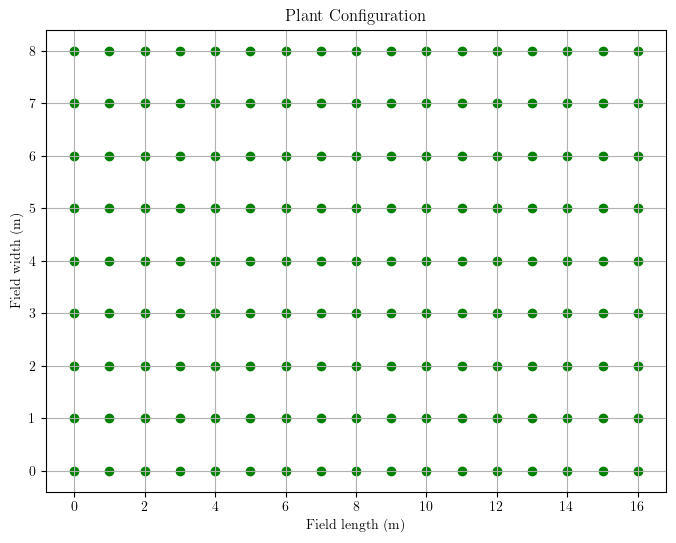

In [8]:
# Set the (x, y) coordinates of the plants
num_plants_x = 17
num_plants_y = 9

field_dim_x = 16
field_dim_y = 8

def generate_2d_plant_coordinates(num_plants_x, num_plants_y, field_dim_x, field_dim_y):

    # Calculate spacing between points
    spacing_x = field_dim_x / (num_plants_x - 1)
    spacing_y = field_dim_y / (num_plants_y - 1)
    
    # Generate coordinates
    coordinates_list_of_tuples = []
    coords_3d_col_row_xy = np.zeros((num_plants_x, num_plants_y, 2))
    for i in range(num_plants_x):
        x = i * spacing_x
        for j in range(num_plants_y):
            y = j * spacing_y
            coords_3d_col_row_xy[i, j] = np.array((x, y))
            coordinates_list_of_tuples.append((x, y))
    
    return coordinates_list_of_tuples, coords_3d_col_row_xy

def plot_2d_plant_coordinates(coordinates_list_of_tuples):

    # Unpack the coordinates into separate x and y lists
    x_coords, y_coords = zip(*coordinates_list_of_tuples)
    
    # Create a plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x_coords, y_coords, color='green')
    plt.xlabel('Field length (m)')
    plt.ylabel('Field width (m)')
    plt.title('Plant Configuration')
    plt.grid(True)
    plt.show()

# Plot the locations of the plants in the field
coordinates_list_of_tuples, coords_3d_col_row_xy = generate_2d_plant_coordinates(num_plants_x, num_plants_y, field_dim_x, field_dim_y)
plot_2d_plant_coordinates(coordinates_list_of_tuples)

# Test that reshaping works as expected
coords_2d_plant_xy = coords_3d_col_row_xy.reshape(num_plants_x * num_plants_y, 2)
xcoords_canopy = coords_2d_plant_xy[:, 0]
ycoords_canopy = coords_2d_plant_xy[:, 1]

In [9]:
# Variable Glossary - Field Configuration
num_plants = num_plants_x * num_plants_y     # number of plants in the field, [unitless]
crop       = key_region_dict[region]['crop'] # crop type,                     [unitless]

field_azimuth_angle = 0  # clockwise rotation of farm origin from north,               [degrees]
field_zenith_angle  = 0  # surface normal of plane in which field lives w.r.t. z-axis, [degrees]  

In [10]:
# Variable Glossary - Simulation Settings
start_solar_position     = SolarPosition(key_region_dict, start_date, region)
end_solar_position       = SolarPosition(key_region_dict, end_date,   region)
total_simulation_days    = end_solar_position.get_number_day() - start_solar_position.get_number_day() # total simulation time in days,         [days]
time_step_size           = 1                                                                           # simulation time step size in hours,    [hours] 
area_leaf_test_point     = 0.005                                                                       # area of leaf test point,               [m2]
density_leaf_test_points = 1/area_leaf_test_point                                                      # density of test points within a leaf,  [points/m2]
num_time_steps_per_day   = int(np.ceil(HOURS_PER_DAY/time_step_size))                                  # number of time steps in one day,       [unitless]
total_time_steps         = total_simulation_days * num_time_steps_per_day                              # total number of simulation time steps, [unitless]

In [11]:
# Variable Glossary - Inital Conditions for Time-Dependent Variables
days_after_sowing       = 0                                # days after sowing,                                          [days]
height                  = 0.01 * np.ones(total_time_steps) # initial height of representative plant,                     [m]
leaf_area               = 0.01 * np.ones(total_time_steps) # initial leaf area of representative plant,                  [m2]
irradiance_leaf_surface = 0.01 * np.ones(total_time_steps) # initial irradiance at leaf surface of representative plant, [W/m2]
canopy_biomass          = 0.01 * np.ones(total_time_steps) # initial canopy biomass of representative plant,             [kg]
fruit_biomass           = 0.01 * np.ones(total_time_steps) # initial fruit biomass of representative plant,              [kg]

In [12]:
# Variable Glossary - Growth Rates
growth_rate_fruit_biomass                 = key_crop_dict[crop]['growth_rate_fruit_biomass'][0]                 # [1/s]
growth_rate_height                        = key_crop_dict[crop]['growth_rate_height'][0]                        # [1/s]
growth_rate_height_fertilizer_specific    = key_crop_dict[crop]['growth_rate_height_fertilizer_specific'][0]    # [1/s]
growth_rate_height_water_specific         = key_crop_dict[crop]['growth_rate_height_water_specific'][0]         # [1/s]
growth_rate_leaf_area_fertilizer_specific = key_crop_dict[crop]['growth_rate_leaf_area_fertilizer_specific'][0] # [1/s]
growth_rate_leaf_area_temp_specific       = key_crop_dict[crop]['growth_rate_leaf_area_temp_specific'][0]       # [1/s]
growth_rate_leaf_area_water_specific      = key_crop_dict[crop]['growth_rate_leaf_area_water_specific'][0]      # [1/s]

In [13]:
# Variable Glossary - Peak Growth Times
peak_growth_time_canopy_biomass                          = key_crop_dict[crop]['peak_growth_time_canopy_biomass'][0]                          # [1/s]
peak_growth_time_leaf_area                               = key_crop_dict[crop]['peak_growth_time_leaf_area'][0]                               # [1/s]
scaling_factor_peak_growth_time_height_water_specific    = key_crop_dict[crop]['scaling_factor_peak_growth_time_height_water_specific'][0]    # [1/s]
scaling_factor_peak_growth_time_leaf_area_temp_specific  = key_crop_dict[crop]['scaling_factor_peak_growth_time_leaf_area_temp_specific'][0]  # [1/s]
scaling_factor_peak_growth_time_leaf_area_water_specific = key_crop_dict[crop]['scaling_factor_peak_growth_time_leaf_area_water_specific'][0] # [1/s]

In [14]:
# Variable Glossary - Other Peak Growth Parameters
scaling_factor_peak_height_growth_water_specific    = key_crop_dict[crop]['scaling_factor_peak_height_growth_water_specific'][0]    # [unitless]
scaling_factor_peak_leaf_area_growth_temp_specific  = key_crop_dict[crop]['scaling_factor_peak_leaf_area_growth_temp_specific'][0]  # [1/s]
scaling_factor_peak_leaf_area_growth_water_specific = key_crop_dict[crop]['scaling_factor_peak_leaf_area_growth_water_specific'][0] # [1/s]

In [15]:
# Variable Glossary - Decay Rates
decay_rate_canopy_biomass           = key_crop_dict[crop]['decay_rate_canopy_biomass'][0]           # [1/s]
decay_rate_fruit_biomass            = key_crop_dict[crop]['decay_rate_fruit_biomass'][0]            # [1/s]
decay_rate_height                   = key_crop_dict[crop]['decay_rate_height'][0]                   # [1/s]
decay_rate_leaf_area_temp_specific  = key_crop_dict[crop]['decay_rate_leaf_area_temp_specific'][0]  # [1/s/degC]
decay_rate_leaf_area_water_specific = key_crop_dict[crop]['decay_rate_leaf_area_water_specific'][0] # [1/kg]

In [16]:
# Variable Glossary - Carrying Capacities
carrying_capacity_canopy_area                   = key_crop_dict[crop]['carrying_capacity_canopy_area'][0]                   # [m2]
carrying_capacity_fruit_biomass                 = key_crop_dict[crop]['carrying_capacity_fruit_biomass'][0]                 # [kg]
carrying_capacity_height                        = key_crop_dict[crop]['carrying_capacity_height'][0]                        # [m]
carrying_capacity_height_fertilizer_specific    = key_crop_dict[crop]['carrying_capacity_height_fertilizer_specific'][0]    # [kg]
carrying_capacity_leaf_area                     = key_crop_dict[crop]['carrying_capacity_leaf_area'][0]                     # [kg]
carrying_capacity_leaf_area_fertilizer_specific = key_crop_dict[crop]['carrying_capacity_leaf_area_fertilizer_specific'][0] # [kg]

In [17]:
# Variable Glossary - Gains from Various Stimuli
gains_height_from_fertilizer    = key_crop_dict[crop]['gains_height_from_fertilizer'][0]    # [m/kg]
gains_height_from_water         = key_crop_dict[crop]['gains_height_from_water'][0]         # [m/kg]
gains_leaf_area_from_fertilizer = key_crop_dict[crop]['gains_leaf_area_from_fertilizer'][0] # [m2/kg]
gains_leaf_area_from_temp       = key_crop_dict[crop]['gains_leaf_area_from_temp'][0]       # [m2/degC]
gains_leaf_area_from_water      = key_crop_dict[crop]['gains_leaf_area_from_water'][0]      # [m2/kg]

In [18]:
# Variable Glossary - Other Crop-specific Parameters
absorption_factor_single_leaf            = key_crop_dict[crop]['absorption_factor_single_leaf'][0]            # [unitless]
canopy_threshold_fruit_growth            = key_crop_dict[crop]['canopy_threshold_fruit_growth'][0]            # [kg]
conal_angle_leaves_wrt_stem              = key_crop_dict[crop]['conal_angle_leaves_wrt_stem'][0]              # [degrees]
efficiency_coefficient_photosynthesis    = key_crop_dict[crop]['efficiency_coefficient_photosynthesis'][0]    # [1/W]
fruit_biomass_temp_sensitivity_parameter = key_crop_dict[crop]['fruit_biomass_temp_sensitivity_parameter'][0] # [unitless]
height_threshold_leaf_growth             = key_crop_dict[crop]['height_threshold_leaf_growth'][0]             # [m]
typical_canopy_density                   = key_crop_dict[crop]['typical_canopy_density'][0]                   # [kg/m3]

In [19]:
# Variable Glossary - Hourly Temperature
temp_ceiling_fruit_growth        = key_crop_dict[crop]['temp_ceiling_fruit_growth'][0]        # [degC]
temp_critical_fruit_growth       = key_crop_dict[crop]['temp_critical_fruit_growth'][0]       # [degC]
temp_optimal_fruit_growth        = key_crop_dict[crop]['temp_optimal_fruit_growth'][0]        # [degC]

all_hourly_temperatures = key_region_dict[region]['nsrdb_data']['Temperature']
hourly_temperatures = np.array(all_hourly_temperatures[start_point:end_point])

In [20]:
# Variable Glossary - Hourly Water Consumption
water_ceiling_fruit_growth       = key_crop_dict[crop]['water_ceiling_fruit_growth'][0]       # [kg]
water_critical_fruit_growth      = key_crop_dict[crop]['water_critical_fruit_growth'][0]      # [kg]
water_optimal_fruit_growth       = key_crop_dict[crop]['water_optimal_fruit_growth'][0]       # [kg"]

all_hourly_water_consumption = np.zeros(all_hourly_temperatures.shape)
water_start_point = get_nsrdb_equiv_point(water_start_date)
water_point_frequency = water_frequency * HOURS_PER_DAY # convert frequency from every x days to every y hours

for point in range(water_start_point, end_point, water_point_frequency):
    all_hourly_water_consumption[point] = water_amount_per_plant * num_plants

# Trim all hourly water consumption to obtain hourly water consumption for target growing period
hourly_water_consumption = np.array(all_hourly_water_consumption[start_point:end_point])

In [21]:
# Variable Glossary - Hourly Fertilizer Consumption
fertilizer_critical_fruit_growth = key_crop_dict[crop]['fertilizer_critical_fruit_growth'][0] # [kg]

all_hourly_fertilizer_consumption = np.zeros(all_hourly_temperatures.shape)
fertilizer_start_point = get_nsrdb_equiv_point(fertilizer_start_date)
fertilizer_point_frequency = fertilizer_frequency * HOURS_PER_DAY # convert frequency from every x days to every y hours

for point in range(fertilizer_start_point, end_point, fertilizer_point_frequency):
    all_hourly_fertilizer_consumption[point] = fertilizer_amount_per_plant * num_plants

# Trim all hourly water consumption to obtain hourly water consumption for target growing period
hourly_fertilizer_consumption = np.array(all_hourly_fertilizer_consumption[start_point:end_point])

In [22]:
def get_initial_irradiance(key_region_dict, date_time, region):

    # Returns the initial irradiance in W/m2 at the Earth's surface in the chosen region
    # Calculated as a sum of DNI, DHI, and GHI
    region_info = key_region_dict[region]
    nsrdb_data = region_info['nsrdb_data']

    i = get_nsrdb_equiv_point(date_time)

    DHI = nsrdb_data['DHI'][i] # diffuse horizontal irradiance [W/m2]
    DNI = nsrdb_data['DNI'][i] # direct normal irradiance      [W/m2]
    GHI = nsrdb_data['GHI'][i] # global horizontal irradiance  [W/m2]

    initial_irradiance = DHI + DNI + GHI

    return initial_irradiance

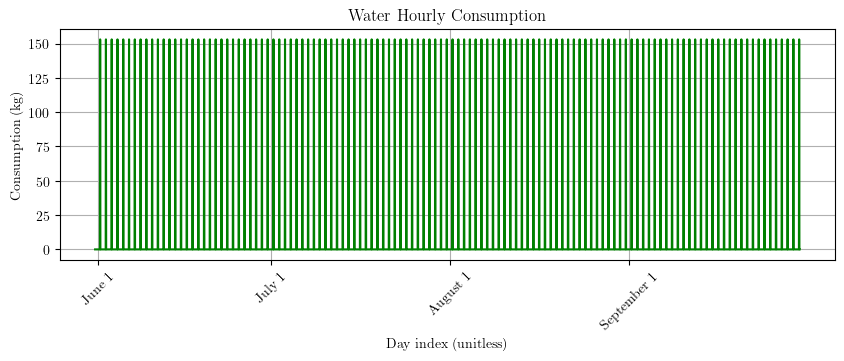

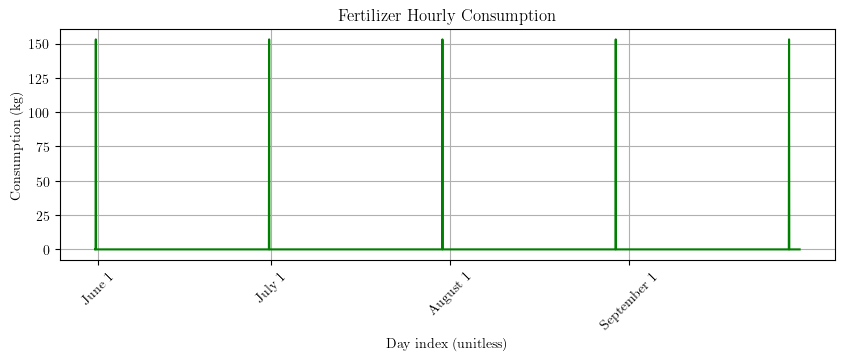

In [23]:
# Plot Hourly Water and Fertilizer Consumption
date_labels_points = []
date_labels_labels = []
for month in range(1, MONTHS_PER_YEAR):
    this_year   = start_year 
    this_month  = month    
    this_day    = 1   
    this_hour   = 0   
    this_minute = 0   
    this_second = 0   
    this_date = datetime(year=this_year, 
                         month=this_month, 
                         day=this_day, 
                         hour=this_hour, 
                         minute=this_minute, 
                         second=this_second)
    date_labels_point = get_nsrdb_equiv_point(this_date)
    if date_labels_point >= start_point and date_labels_point <= end_point:
        date_labels_points.append(date_labels_point)
        date_labels_labels.append(f'{this_date.strftime('%B')} {this_date.day}')

def plot_consumption(hourly_consumption, consumption_type, date_labels_points, date_labels_labels):
    
    consumption = hourly_consumption.flatten()
    plt.figure(figsize=(10, 3))
    plt.plot(range(start_point, end_point), consumption, color='green')
    plt.xlabel('Day index (unitless)')
    plt.ylabel('Consumption (kg)')
    plt.title(f'{consumption_type} Hourly Consumption')
    plt.xticks(ticks=date_labels_points, labels=date_labels_labels, rotation=45)
    plt.grid(True)
    plt.show()

plot_consumption(hourly_water_consumption, 'Water', date_labels_points, date_labels_labels)
plot_consumption(hourly_fertilizer_consumption, 'Fertilizer', date_labels_points, date_labels_labels)

In [24]:
# Convert angles in degrees to radians
field_azimuth_angle = math.radians(field_azimuth_angle)
field_zenith_angle  = math.radians(field_zenith_angle) 
conal_angle_leaves_wrt_stem = math.radians(conal_angle_leaves_wrt_stem)

In [28]:
#----- MAIN SIMULATION -----#

# Set cumulative values to zero before simulation begins
cumulative_temperature = 0 # [degC-hour]
cumulative_irrigation  = 0 # [kg-hour]

# Set triggers
height_decay_triggered = False
leaf_decay_triggered   = False
fruit_decay_triggered  = False

# Begin simulation
todays_date = start_date
for day in range(total_simulation_days):

    # Print out the day
    print(f'Day {day+1} of {total_simulation_days}')

    # Update days after sowing and today's date
    days_after_sowing += 1
    todays_date += timedelta(days=1)

    # Update the cumulative temperature model (updates daily)
    todays_temperatures     = hourly_temperatures[day*HOURS_PER_DAY:(day+1)*HOURS_PER_DAY]
    average_temperature     = np.mean(todays_temperatures)
    effective_temperature   = np.mean(todays_temperatures - temp_critical_fruit_growth)
    cumulative_temperature += effective_temperature * time_step_size
    leaf_sensitivity_temp   = (temp_optimal_fruit_growth - temp_critical_fruit_growth)/(average_temperature - temp_critical_fruit_growth)

    fruit_sensitivity_temp = 0 # placeholder
    if average_temperature <= temp_optimal_fruit_growth:
        fruit_sensitivity_temp = 1
    elif average_temperature > temp_optimal_fruit_growth and average_temperature < temp_ceiling_fruit_growth:
        fruit_sensitivity_temp = 1 - np.abs(1 - fruit_biomass_temp_sensitivity_parameter / leaf_sensitivity_temp)
    else:
        fruit_sensitivity_temp = 0

    # Update the cumulative irrigation model (updates daily)
    todays_irrigation      = hourly_water_consumption[day*HOURS_PER_DAY:(day+1)*HOURS_PER_DAY]
    average_irrigation     = np.mean(todays_irrigation)
    effective_irrigation   = np.mean(todays_irrigation - water_critical_fruit_growth)
    if effective_irrigation < 0: effective_irrigation = 0.01
    cumulative_irrigation += effective_irrigation * time_step_size
    leaf_sensitivity_water = (water_optimal_fruit_growth - water_critical_fruit_growth)/(average_irrigation - water_critical_fruit_growth)

    # Update the effective fertilizer model (updates daily)
    todays_fertilizer    = hourly_fertilizer_consumption[day*HOURS_PER_DAY:(day+1)*HOURS_PER_DAY]
    average_fertilizer   = np.mean(todays_fertilizer)
    effective_fertilizer = np.mean(todays_fertilizer - fertilizer_critical_fruit_growth)
    if effective_fertilizer < 0: effective_fertilizer = 0.01

    # Loop over time steps (for updates that happen periodically throughout a single day)
    for time_step in range(num_time_steps_per_day):

        # Index for time-dependent variables
        t = day * num_time_steps_per_day + time_step
        if t == total_time_steps-1:
            break # cannot fill the t+1 position if this condition is true, so break the loop
        #print(f'Day {day} of {total_simulation_days} | time step {time_step} of {num_time_steps_per_day} | time step {t} of {total_time_steps}')

        # Update today's date to the hour
        todays_date += timedelta(hours=time_step_size)

        # Initialize an instance of the SolarPosition class based on latest time
        current_solar_position = SolarPosition(key_region_dict=key_region_dict, date_time=todays_date, region=region)

        '''TODO debug with NOAA formulas'''
        solar_azimuth_angle = math.radians(current_solar_position.get_solar_azimuth_angle()) # TODO, debug with NOAA formulas
        solar_zenith_angle  = math.radians(current_solar_position.get_solar_zenith_angle())  # TODO, debug with NOAA formulas
        initial_rad         = get_initial_irradiance(key_region_dict, todays_date, region)

        # Evaluate the time derivatives of height and leaf area: dhdt and dAdt 
        if height[t] > carrying_capacity_height:
            height_decay_triggered = True
        if height_decay_triggered:
            dhdt = growth_rate_height * height[t] * (1 - height[t]/carrying_capacity_height) \
                + gains_height_from_water * growth_rate_height_water_specific * effective_irrigation \
                    * np.exp(-((cumulative_irrigation - scaling_factor_peak_height_growth_water_specific * effective_irrigation)/\
                               (scaling_factor_peak_growth_time_height_water_specific * effective_irrigation))**2) \
                + gains_height_from_fertilizer * growth_rate_height_fertilizer_specific * effective_fertilizer \
                    * (1 - effective_fertilizer/carrying_capacity_height_fertilizer_specific) \
                - decay_rate_height * height[t]
        else:
            dhdt = growth_rate_height * height[t] * (1 - height[t]/carrying_capacity_height) \
                + gains_height_from_water * growth_rate_height_water_specific * effective_irrigation \
                    * np.exp(-((cumulative_irrigation - scaling_factor_peak_height_growth_water_specific * effective_irrigation)/\
                               (scaling_factor_peak_growth_time_height_water_specific * effective_irrigation))**2) \
                + gains_height_from_fertilizer * growth_rate_height_fertilizer_specific * effective_fertilizer \
                    * (1 - effective_fertilizer/carrying_capacity_height_fertilizer_specific)
        
        dAdt = 0
        if height[t] > height_threshold_leaf_growth:
            # Seedling --> vegetative transition
            if leaf_area[t] > carrying_capacity_leaf_area:
                leaf_decay_triggered = True
            if leaf_decay_triggered:
                dAdt = gains_leaf_area_from_temp * growth_rate_leaf_area_temp_specific * effective_temperature \
                    * np.exp(-((cumulative_temperature - scaling_factor_peak_leaf_area_growth_temp_specific * effective_temperature)/ \
                                (scaling_factor_peak_growth_time_leaf_area_temp_specific * effective_temperature))**2) \
                    + gains_leaf_area_from_water * growth_rate_leaf_area_water_specific * effective_irrigation \
                        * np.exp(-((cumulative_irrigation - scaling_factor_peak_leaf_area_growth_water_specific * effective_irrigation)/ \
                                    (scaling_factor_peak_growth_time_leaf_area_water_specific * effective_irrigation))**2) \
                    + gains_leaf_area_from_fertilizer * growth_rate_leaf_area_fertilizer_specific * effective_fertilizer \
                        * (1 - effective_fertilizer/carrying_capacity_leaf_area_fertilizer_specific) \
                    - decay_rate_leaf_area_temp_specific * leaf_sensitivity_temp * leaf_area[t] \
                    - decay_rate_leaf_area_water_specific * leaf_sensitivity_water * leaf_area[t]
            else:
                dAdt = gains_leaf_area_from_temp * growth_rate_leaf_area_temp_specific * effective_temperature \
                    * np.exp(-((cumulative_temperature - scaling_factor_peak_leaf_area_growth_temp_specific * effective_temperature)/ \
                                (scaling_factor_peak_growth_time_leaf_area_temp_specific * effective_temperature))**2) \
                    + gains_leaf_area_from_water * growth_rate_leaf_area_water_specific * effective_irrigation \
                        * np.exp(-((cumulative_irrigation - scaling_factor_peak_leaf_area_growth_water_specific * effective_irrigation)/ \
                                    (scaling_factor_peak_growth_time_leaf_area_water_specific * effective_irrigation))**2) \
                    + gains_leaf_area_from_fertilizer * growth_rate_leaf_area_fertilizer_specific * effective_fertilizer \
                        * (1 - effective_fertilizer/carrying_capacity_leaf_area_fertilizer_specific)
        else:
            dAdt = 0

        # Use the derivatives to update the height and leaf area with Forward Euler
        height[t+1] = height[t] + dhdt * time_step_size
        leaf_area[t+1] = leaf_area[t] + dAdt * time_step_size

        # For each of the plants, determine how well light passes through the canopy
        # First, circumscribe squares about the circles that represents the canopies
        radius = np.sqrt(leaf_area[t]/np.pi)
        square_side_lengths = 2 * radius

        # Get the coordinates that define the center of the lower left plant (our representative plants)
        xcoord_canopy = coords_2d_plant_xy[0, 0]
        ycoord_canopy = coords_2d_plant_xy[0, 1]

        # Get the coordinates that define the lower left corners of the squares
        start_x_square = xcoord_canopy - radius
        start_y_square = ycoord_canopy - radius

        # Discretize the canopy of each plant - find how to discretize in x and y
        side_length_leaf_test_point = np.sqrt(area_leaf_test_point)
        num_test_points_x_per_plant = int(np.floor(square_side_lengths / side_length_leaf_test_point))
        num_test_points_y_per_plant = num_test_points_x_per_plant

        # Calculate the canopy density for each plant
        canopy_density = 0
        if leaf_area[t] != 0:
            canopy_density = 3 * canopy_biomass[t] / leaf_area[t] * np.sqrt(np.pi/leaf_area[t]) * math.tan(conal_angle_leaves_wrt_stem)
        else:
            canopy_density = 0

        conal_angle_leaves_wrt_origin = conal_angle_leaves_wrt_stem + field_zenith_angle

        # For the representative plant, tile the square that circumscribes the canopy       
        avg_irradiance_leaf_surface = initial_rad 
        for j in range(num_test_points_x_per_plant):
            x = start_x_square + j * side_length_leaf_test_point
            for k in range(num_test_points_y_per_plant):
                y = start_y_square + k * side_length_leaf_test_point

                # Only evaluate irradiance at test point if it is within the canopy
                r = np.sqrt(x**2 + y**2)
                if r <= radius:

                    # Calculate the azimuthal angle of the point
                    azimuth_angle_test_point_wrt_stem = math.tan(y/x) # radians
                    azimuth_angle_test_point_wrt_origin = azimuth_angle_test_point_wrt_stem + field_azimuth_angle
                    
                    # Calculated just in case, but unused for now
                    '''
                    radius_wrt_stem = np.sqrt(x**2 + y**2)
                    z_wrt_height = radius_wrt_stem * 1/math.tan(conal_angle_leaves_wrt_stem)
                    '''

                    # Calculate the extinction coefficient for this test_point
                    extinction_angle_photosynthesis = conal_angle_leaves_wrt_origin - solar_zenith_angle * math.cos(azimuth_angle_test_point_wrt_origin - solar_azimuth_angle)
                    extinction_coefficient_photosynthesis = math.sin(extinction_angle_photosynthesis)

                    # Calculate the irradiance at this test point
                    irradiance_test_point = initial_rad * (1 - np.exp(-extinction_coefficient_photosynthesis * canopy_density/typical_canopy_density))

                    # Update the average irradiance across this canopy
                    avg_irradiance_leaf_surface = (avg_irradiance_leaf_surface + irradiance_test_point)/2

        # Update the total irradiance at the leaf surface for the representative plant     
        irradiance_leaf_surface = avg_irradiance_leaf_surface
            
        # Evaluate the time derivatives of canopy biomass and fruit biomass: dcdt and dPdt
        if dAdt == 0:
            dcdt = 0
        else:
            dcdt = efficiency_coefficient_photosynthesis * irradiance_leaf_surface * dAdt \
                   * canopy_biomass[t] * (1 - canopy_biomass[t]/carrying_capacity_canopy_area) - decay_rate_canopy_biomass * canopy_biomass[t]

        dPdt = 0
        if canopy_biomass[t] > canopy_threshold_fruit_growth:
            
            if fruit_biomass[t] > carrying_capacity_fruit_biomass:
                fruit_decay_triggered = True

                if fruit_decay_triggered:
                    # Vegetative --> flowering/fruiting transition
                    dPdt = growth_rate_fruit_biomass * fruit_sensitivity_temp * dcdt * fruit_biomass[t] \
                        * (1 - fruit_biomass[t]/canopy_biomass) - decay_rate_fruit_biomass * fruit_biomass[t]    
                else:
                    dPdt = growth_rate_fruit_biomass * fruit_sensitivity_temp * dcdt * fruit_biomass[t] \
                        * (1 - fruit_biomass[t]/canopy_biomass) - decay_rate_fruit_biomass * fruit_biomass[t] 
                    
            else:
                dPdt = 0

        # Use the derivatives to update the canopy biomass and fruit biomass with Forward Euler
        canopy_biomass[t+1] = canopy_biomass[t] + dcdt * time_step_size
        fruit_biomass[t+1] = fruit_biomass[t] + dPdt * time_step_size

Day 1 of 122
Day 2 of 122
Day 3 of 122
Day 4 of 122
Day 5 of 122
Day 6 of 122
Day 7 of 122
Day 8 of 122
Day 9 of 122
Day 10 of 122
Day 11 of 122
Day 12 of 122
Day 13 of 122
Day 14 of 122
Day 15 of 122
Day 16 of 122
Day 17 of 122
Day 18 of 122
Day 19 of 122
Day 20 of 122
Day 21 of 122
Day 22 of 122
Day 23 of 122
Day 24 of 122
Day 25 of 122
Day 26 of 122
Day 27 of 122
Day 28 of 122
Day 29 of 122
Day 30 of 122
Day 31 of 122
Day 32 of 122
Day 33 of 122
Day 34 of 122
Day 35 of 122
Day 36 of 122
Day 37 of 122
Day 38 of 122
Day 39 of 122
Day 40 of 122
Day 41 of 122
Day 42 of 122
Day 43 of 122
Day 44 of 122
Day 45 of 122
Day 46 of 122
Day 47 of 122
Day 48 of 122
Day 49 of 122
Day 50 of 122
Day 51 of 122
Day 52 of 122
Day 53 of 122
Day 54 of 122
Day 55 of 122
Day 56 of 122
Day 57 of 122
Day 58 of 122
Day 59 of 122
Day 60 of 122
Day 61 of 122
Day 62 of 122
Day 63 of 122
Day 64 of 122
Day 65 of 122
Day 66 of 122
Day 67 of 122
Day 68 of 122
Day 69 of 122
Day 70 of 122
Day 71 of 122
Day 72 of 122
D

/var/folders/fl/91zckx656v5f4h8x1sh87tfr0000gn/T/ipykernel_1444/503606195.py:84: RuntimeWarning: overflow encountered in scalar multiply
  dhdt = growth_rate_height * height[t] * (1 - height[t]/carrying_capacity_height) \


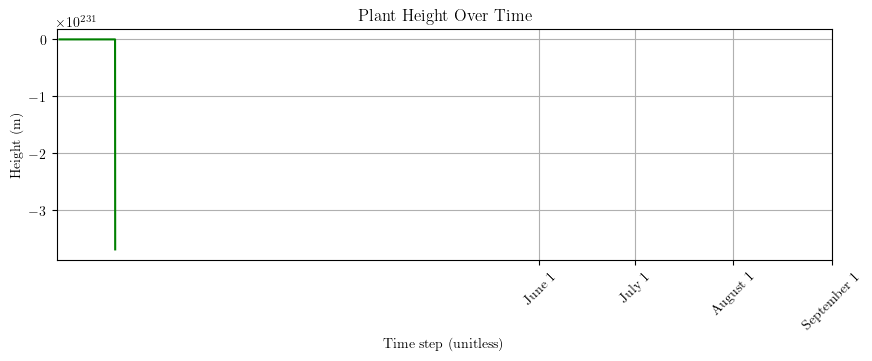

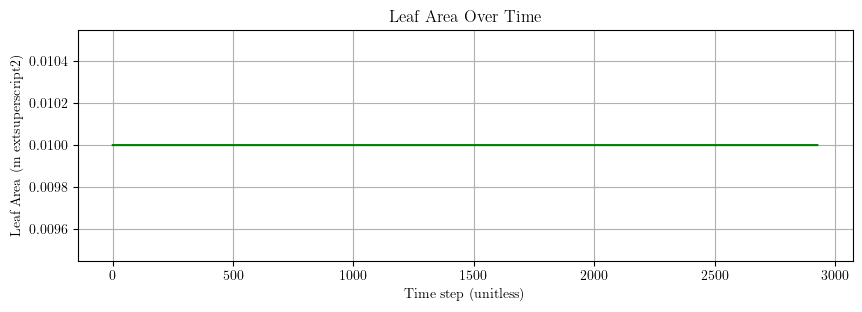

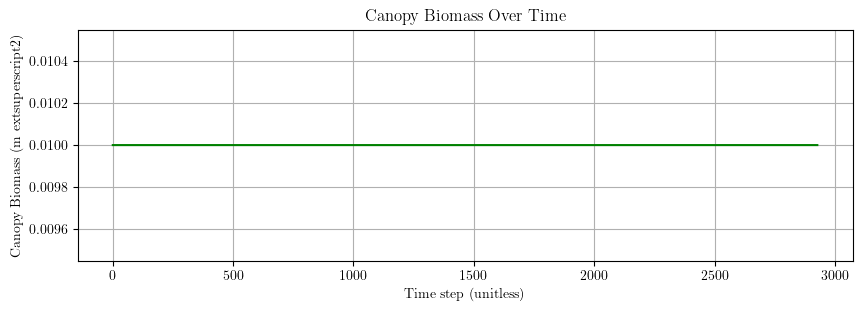

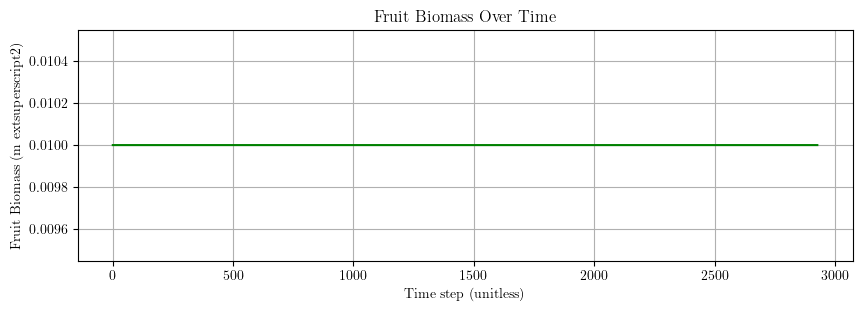

In [33]:
# Plot the time-dependent variables

# Height
plt.figure(figsize=(10, 3))
plt.plot(np.arange(total_time_steps), height, color='green')
plt.xlabel('Time step (unitless)')
plt.ylabel('Height (m)')
plt.title(f'Plant Height Over Time')
#plt.xticks(ticks=date_labels_points, labels=date_labels_labels, rotation=45) # Fix
plt.grid(True)
plt.show()

# Leaf Area
plt.figure(figsize=(10, 3))
plt.plot(np.arange(total_time_steps), leaf_area, color='green')
plt.xlabel('Time step (unitless)')
plt.ylabel('Leaf Area (m\textsuperscript{2})')
plt.title(f'Leaf Area Over Time')
#plt.xticks(ticks=date_labels_points, labels=date_labels_labels, rotation=45)
plt.grid(True)
plt.show()

# Canopy Biomass
plt.figure(figsize=(10, 3))
plt.plot(np.arange(total_time_steps), canopy_biomass, color='green')
plt.xlabel('Time step (unitless)')
plt.ylabel('Canopy Biomass (m\textsuperscript{2})')
plt.title(f'Canopy Biomass Over Time')
#plt.xticks(ticks=date_labels_points, labels=date_labels_labels, rotation=45)
plt.grid(True)
plt.show()

# Fruit Biomass
plt.figure(figsize=(10, 3))
plt.plot(np.arange(total_time_steps), canopy_biomass, color='green')
plt.xlabel('Time step (unitless)')
plt.ylabel('Fruit Biomass (m\textsuperscript{2})')
plt.title(f'Fruit Biomass Over Time')
#plt.xticks(ticks=date_labels_points, labels=date_labels_labels, rotation=45)
plt.grid(True)
plt.show()

In [ ]:
# Genetic Algorithm Helper Functions

def sort(pi):
    new_pi = np.sort(pi, axis=0)
    ind = np.argsort(pi, axis=0)
    return [new_pi, ind]

def reorder(Lambda, ind):
    temp = np.zeros((S,dv))
    for i in range(0, len(ind)):
        temp[i,:] = Lambda[int(ind[i]),:]
    Lambda = temp
    return Lambda

def get_unique_designs(Lambda, costs):

    # Costs are often equal to >10 decimal points
    # Truncate to obtain a richer set of suggestions
    new_costs = np.round(costs, decimals=3)
    
    # Obtain Unique Strings and Costs
    [unique_costs, iuniq] = np.unique(new_costs, return_index=True)
    unique_strings = Lambda[iuniq]

    return [unique_strings, unique_costs] 


In [ ]:
## Cost Function Definition

# An anonymous function for evaluating fitness
def Pi(Lambda):

    # Extract design parameters from genetic string
    k1, mu1, sig1E, K1, k2, mu2, sig2E, K2, v1, gamma = [float(elem) for elem in Lambda]
    v2 = 1 - v1  

    ## Min and Max Effective Property Bounds
    # Bounds on electrical conductivity
    sigE_min = sig1E + v2 / (1/(sig2E - sig1E) + v1/(3*sig1E))
    sigE_max = sig2E + v1 / (1/(sig1E - sig2E) + v2/(3*sig2E))
    
    # Bounds on thermal conducitivity
    K_min = K1 + v2 / (1/(K2 - K1) + v1/(3*K1))
    K_max = K2 + v1 / (1/(K1 - K2) + v2/(3*K2))
    
    # Bounds on bulk modulus
    k_min = k1 + v2 / (1/(k2 -k1) + 3*v1/(3*k1 + 4*mu1))
    k_max = k2 + v1 / (1/(k1 -k2) + 3*v2/(3*k2 + 4*mu2))
    
    # Bounds on shear modulus
    mu_min = mu1 + v2 / (1/(mu2 - mu1) + 6*v1*(k1 + 2*mu1) / (5*mu1*(3*k1 + 4*mu1)))
    mu_max = mu2 + v1 / (1/(mu1 - mu2) + 6*v2*(k2 + 2*mu2) / (5*mu2*(3*k2 + 4*mu2)))
    
    ## Effective Material Properties
    sigE_eff = gamma * sigE_max + (1 - gamma) * sigE_min
    K_eff    = gamma * K_max    + (1 - gamma) * K_min
    k_eff    = gamma * k_max    + (1 - gamma) * k_min
    mu_eff   = gamma * mu_max   + (1 - gamma) * mu_min
    
    ## Concentration Tensor Determination
    # Electrical Load Sharing
    CJ1CE1 = sig1E/sigE_eff * (1/v1 * (sig2E - sigE_eff)/(sig2E - sig1E))**2
    CJ2CE2 = sig2E/sigE_eff * (1/v2 * (sig1E - sigE_eff)/(sig1E - sig2E))**2
    
    # Thermal Load Sharing
    Ct2 = 1/v2 * (K_eff - K1) / (K2 - K1) 
    Ct1 = 1/v1 * (1 - v2 * Ct2) 
    Cq2 = K2 * Ct2 * 1/K_eff
    Cq1 = 1/v1 * (1 - v2 * Cq2)
        
    # Mechanical Load Sharing
    Ck2  = 1/v2 * k2/k_eff   * (k_eff - k1) / (k2 - k1)
    Cmu2 = 1/v2 * mu2/mu_eff * (mu_eff - mu1)/(mu2 - mu1)
    Ck1  = 1/v1 * (1 - v2 * Ck2)
    Cmu1 = 1/v1 * (1 - v2 * Cmu2)
    
    ## Cost Function Weight Determination
    # Assign concentration tensor weights
    w2E = wj
    w3E = wj
    w2T = wj
    w3T = wj
    w3M = wj
    w4M = wj
    w5M = wj
    w6M = wj
    
    # Electrical weights
    if (CJ1CE1 - TOL_sig) / TOL_sig > 0:
        w2E_hat = w2E
    else:
        w2E_hat = 0

    if (CJ2CE2 - TOL_sig) / TOL_sig > 0:
        w3E_hat = w3E
    else:
        w3E_hat = 0
    
    # Thermal weights
    if (Cq1 - TOL_K) / TOL_K > 0:
        w2T_hat = w2T
    else:
        w2T_hat = 0

    if (Cq2 - TOL_K) / TOL_K > 0:
        w3T_hat = w3T
    else:
        w3T_hat = 0
    
    # Mechanical weights
    if (Ck2 - TOL_k) > 0:
        w3M_hat = w3M
    else:
        w3M_hat = 0

    if (Cmu2 - TOL_mu) > 0:
        w4M_hat = w4M
    else:
        w4M_hat = 0

    if (Ck1 - TOL_k) > 0:
        w5M_hat = w5M
    else:
        w5M_hat = 0

    if (Cmu1 - TOL_mu) > 0:
        w6M_hat = w6M
    else:
        w6M_hat = 0

    ## Cost Functions
    # Electrical Property Cost Function
    Pi_elec = w1      * abs((sigE_effD - sigE_eff) / sigE_effD) \
            + w2E_hat * abs((CJ1CE1   - TOL_sig)   / TOL_sig) \
            + w3E_hat * abs((CJ2CE2   - TOL_sig)   / TOL_sig)

    # Thermal Property Cost Function    
    Pi_thermo = w1      * abs((K_effD - K_eff) / K_effD) \
              + w2T_hat * abs((Cq1    - TOL_K) / TOL_K) \
              + w3T_hat * abs((Cq2    - TOL_K) / TOL_K)
        
    # Mechanical Property Cost Function
    Pi_mech = w1      * abs((k_effD  - k_eff) / k_effD) \
            + w1      * abs((mu_effD - mu_eff)/ mu_effD) \
            + w3M_hat * abs((Ck2     - TOL_k) / TOL_k) \
            + w4M_hat * abs((Cmu2    - TOL_mu)/ TOL_mu) \
            + w5M_hat * abs((Ck1     - TOL_k) / TOL_k) \
            + w6M_hat * abs((Cmu1    - TOL_mu)/ TOL_mu)

    # Multi-property (Combined) Cost Function
    cost = W1 * Pi_elec + W2 * Pi_thermo + W3 * Pi_mech

    return cost

In [ ]:
## Material Property Optimization, CASE A 
# - Keep the top P=10 parents after each generation
# - Produce 10 offspring
# - Generate 180 new random strings

def caseA():
    
    # Initialize arrays to store the cost and original indices of each generation
    PI = np.ones((G, S))
    Orig = np.ones((G, S))
    
    # Initialize arrays to store best performer and parent avg 
    Pi_min = np.zeros(G)     # best cost
    Pi_par_avg = np.zeros(G) # avg cost of parents
    
    # Generation counter
    g = 0

    # Initialize array to store costs for current generation
    cost = np.zeros(S)

    # Randomly populate first generation  
    Lambda = np.ones((S, dv))
    for i in range (S):
        Lambda[i, :] = np.random.uniform(lower_bounds, upper_bounds)
        cost[i] = Pi(Lambda[i, :])
            
    # Sort the costs of the first generation
    [new_cost, ind] = sort(cost)  
    PI[g, :] = new_cost.reshape(1,S) 
    
    # Store the cost of the best performer and average cost of the parents 
    Pi_min[g] = np.min(new_cost)
    Pi_par_avg[g] = np.mean(new_cost[0:P])
    
    # Update Lambda based on sorted indices
    Lambda = reorder(Lambda, ind)
    Orig[g,:] = ind.reshape(1,S) 
    
    # Perform all later generations    
    while g < G:
        
        print(g)
        cost[0:P] = new_cost[0:P] # retain the parents from the previous generation
        
        # Select top parents P from Lambda to be breeders
        for p in range(0, P, 2):
            phi1, phi2 = np.random.rand(2)
            kid1 = phi1*Lambda[p, :] + (1-phi1)*Lambda[p+1, :]
            kid2 = phi2*Lambda[p, :] + (1-phi2)*Lambda[p+1, :]
            
            # Append offspring to Lambda 
            Lambda[P+p,   :] = kid1
            Lambda[P+p+1, :] = kid2
        
            # Evaluate Offspring
            cost[P+p]   = Pi(Lambda[P+p, :])
            cost[P+p+1] = Pi(Lambda[P+p+1, :])
                     
        # Randomly generate new design strings to fill th rest of the population
        for i in range(S-P-K):
            Lambda[P+K+i, :] = np.random.uniform(lower_bounds, upper_bounds)
            cost[P+K+i] = Pi(Lambda[P+K+i, :])

        # Sort the costs for the gth generation
        [new_cost, ind] = sort(cost)  
        PI[g, :] = new_cost.reshape(1,S) 
    
        # Store the cost of the best performer and average cost of the parents 
        Pi_min[g] = np.min(new_cost)
        Pi_par_avg[g] = np.mean(new_cost[0:P])
    
        # Update Lambda based on sorted indices
        Lambda = reorder(Lambda, ind)
        Orig[g,:] = ind.reshape(1,S)  

        # Update the generation counter
        g = g + 1          
    
    return PI, Lambda, Orig, Pi_min, Pi_par_avg         


In [ ]:
# Call the Genetic Algorithm for Case A  
PI, Lambda, Orig, Pi_min, Pi_par_avg = caseA() # Keep the top P=10 parents after each generation
                                               # Produce 10 offspring
                                               # Generate 180 new random strings